## Random Forest diagonal feeding

$q_{i,t}$ - demand for item $i$ in period t

$q_{i,t}^f$ - demand for item $i$ at the end of month t, through orders made f months in advance

In [ ]:
import pandas as pd
!conda install -c conda-forge jupyterlab

In [92]:
def plt_2_gr(y_quantity_item,y_predicted,text ):
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
    plt.plot(y_predicted, label = 'Predicted quantity')
    plt.xlabel('rpd')
    plt.ylabel('quantity')
    plt.title(text)
    plt.legend(); 
    return fig

In [4]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
df.head()

,rpd,item,quantity_ecd,future_flag
0,109,10106,400,0
1,109,10106,400,1
2,110,10106,2000,0
3,110,10106,2000,1
4,124,10106,800,0


In [5]:
df = df.set_index(["item", "rpd", "future_flag"]).sort_index()

In [6]:
#df = df.sort_values(['item','rpd','future_flag'])
df.head()

quantity_ecd
item  rpd future_flag              
10106 109 0                     400
          1                     400
      110 0                    2000
          1                    2000
      124 0                     800

In [7]:
demand_total = df["quantity_ecd"].unstack(fill_value=0)

In [8]:
demand_total.head()

future_flag     0     1  2  3
item  rpd                    
10106 109     400   400  0  0
      110    2000  2000  0  0
      124     800   800  0  0
      130    7400  7400  0  0
      132    6400  6400  0  0

In [9]:
demand_delta = demand_total - demand_total.shift(periods=-1, axis=1).fillna(0.)
demand_delta.head()

future_flag    0       1    2    3
item  rpd                         
10106 109    0.0   400.0  0.0  0.0
      110    0.0  2000.0  0.0  0.0
      124    0.0   800.0  0.0  0.0
      130    0.0  7400.0  0.0  0.0
      132    0.0  6400.0  0.0  0.0

In [10]:
qty_total = demand_total.unstack("item", fill_value=0.)
qty_total.head()

future_flag       0                                                         \
item          10106 10362  10601 10646  10659 10705 10756      10949 11011   
rpd                                                                          
108             0.0   0.0    0.0   0.0    0.0   0.0   0.0  1202000.0   0.0   
109           400.0   0.0    0.0   0.0    0.0   0.0   0.0   969000.0   0.0   
110          2000.0   0.0    0.0   0.0    0.0   0.0   0.0  1535000.0   0.0   
111             0.0   0.0  200.0   0.0  600.0   0.0   0.0  2695400.0   0.0   
112             0.0   0.0    0.0   0.0  200.0   0.0   0.0  2170800.0   0.0   

future_flag        ...      3                                                  \
item        11306  ...  99465 99520 99570 99593 99691 99811 99848 99871 99938   
rpd                ...                                                          
108           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
109           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
110           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
111           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
112           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

future_flag        
item        99964  
rpd                
108           0.0  
109           0.0  
110           0.0  
111           0.0  
112           0.0  

[5 rows x 3344 columns]

In [11]:
qty_delta = demand_delta.unstack("item", fill_value=0.)
qty_delta.head()

future_flag     0                                                            \
item        10106 10362 10601 10646 10659 10705 10756     10949 11011 11306   
rpd                                                                           
108           0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0   0.0   0.0   
109           0.0   0.0   0.0   0.0   0.0   0.0   0.0   37000.0   0.0   0.0   
110           0.0   0.0   0.0   0.0   0.0   0.0   0.0   10000.0   0.0   0.0   
111           0.0   0.0   0.0   0.0   0.0   0.0   0.0  458400.0   0.0   0.0   
112           0.0   0.0   0.0   0.0   0.0   0.0   0.0  201400.0   0.0   0.0   

future_flag  ...      3                                                        
item         ...  99465 99520 99570 99593 99691 99811 99848 99871 99938 99964  
rpd          ...                                                               
108          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
109          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
110          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
111          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
112          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 3344 columns]

In [12]:
def make_Xy(data, n_order=1):
    n_ahead = data.shape[1]

    # get (q^h_s)_{s\leq t + h, h=0..3} -- ar(1) and anticipatory features (known by t)
    data_X = pd.concat([
        data.shift(-h).rename(columns=f"{h}-{{}}".format).iloc[:, h:]
        for h in range(n_ahead)
    ], axis=1)

    # get q^h_{:t} -- autoregressive features (known by t-h-1)
    if n_order == 1:
        data_X = data_X.shift(1)

    else:
        data_X = pd.concat([
            data_X.shift(lag).rename(f"{lag}-{{}}".format, axis=1)
            for lag in range(1, n_order + 1)
        ], axis=1)
    # end if

    # get (q^h_{t+s})_{h < s, s=1..4} -- current target (known at t+1, t+2, t+3 and t+4)
    data_y = pd.concat([
        data.shift(-h).rename(columns=f"{h+1}-{{}}".format).iloc[:, :h+1]
        for h in range(n_ahead)
    ], axis=1)

    # return data_X, data_y

    # X and y are already properly shifted and thus the NaNs can just be dropped
    data_X, data_y = data_X.dropna(), data_y.dropna()
    return data_X.align(data_y, join="inner", axis=0)

In [13]:
#t = make_Xy(qty_total)

Let's make it clear, by taking specific item_code and working with it:

In [166]:
item_ = df.filter(like= '96815',axis = 0)

In [167]:
demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
demand_total_item.head()

future_flag       0       1      2     3
item  rpd                               
96815 108     22200   20800      0     0
      109     29600   23800      0     0
      110     51400   43600  26200  6000
      111    136200  123800   6200  6200
      112     55000   48600   3600   200

In [168]:
demand_delta_item = demand_total_item - demand_total_item.shift(periods=-1, axis=1).fillna(0.)
demand_delta_item.head()

future_flag        0         1        2       3
item  rpd                                      
96815 108     1400.0   20800.0      0.0     0.0
      109     5800.0   23800.0      0.0     0.0
      110     7800.0   17400.0  20200.0  6000.0
      111    12400.0  117600.0      0.0  6200.0
      112     6400.0   45000.0   3400.0   200.0

In [169]:
qty_total_item = demand_total_item.unstack("item", fill_value=0.)
qty_total_item.head()

future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,22200,20800,0,0
109,29600,23800,0,0
110,51400,43600,26200,6000
111,136200,123800,6200,6200
112,55000,48600,3600,200


In [170]:
qty_delta_item = demand_delta_item.unstack("item", fill_value=0.)
qty_delta_item.head()


future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,1400.0,20800.0,0.0,0.0
109,5800.0,23800.0,0.0,0.0
110,7800.0,17400.0,20200.0,6000.0
111,12400.0,117600.0,0.0,6200.0
112,6400.0,45000.0,3400.0,200.0


## Matrix feeding:

In [201]:
t = make_Xy(qty_total_item)

In [202]:
make_Xy(qty_total_item.xs(96815, axis=1, level=-1))[0]

future_flag,0-0,0-1,0-2,0-3,1-1,1-2,1-3,2-2,2-3,3-3
rpd,,,,,,,,,,
109,22200.0,20800.0,0.0,0.0,23800.0,0.0,0.0,26200.0,6000.0,6200.0
110,29600.0,23800.0,0.0,0.0,43600.0,26200.0,6000.0,6200.0,6200.0,200.0
111,51400.0,43600.0,26200.0,6000.0,123800.0,6200.0,6200.0,3600.0,200.0,3200.0
112,136200.0,123800.0,6200.0,6200.0,48600.0,3600.0,200.0,13600.0,3200.0,4000.0
113,55000.0,48600.0,3600.0,200.0,17800.0,13600.0,3200.0,6000.0,4000.0,1400.0
114,36000.0,17800.0,13600.0,3200.0,46000.0,6000.0,4000.0,2000.0,1400.0,0.0
115,57000.0,46000.0,6000.0,4000.0,40600.0,2000.0,1400.0,6400.0,0.0,4800.0
116,43200.0,40600.0,2000.0,1400.0,49400.0,6400.0,0.0,32800.0,4800.0,600.0
117,60000.0,49400.0,6400.0,0.0,70200.0,32800.0,4800.0,6400.0,600.0,12000.0


In [203]:
t_delta = make_Xy(qty_delta_item)
t[0].head()

future_flag,0-0,0-1,0-2,0-3,1-1,1-2,1-3,2-2,2-3,3-3
item,0-96815,0-96815,0-96815,0-96815,1-96815,1-96815,1-96815,2-96815,2-96815,3-96815
rpd,,,,,,,,,,
109,22200.0,20800.0,0.0,0.0,23800.0,0.0,0.0,26200.0,6000.0,6200.0
110,29600.0,23800.0,0.0,0.0,43600.0,26200.0,6000.0,6200.0,6200.0,200.0
111,51400.0,43600.0,26200.0,6000.0,123800.0,6200.0,6200.0,3600.0,200.0,3200.0
112,136200.0,123800.0,6200.0,6200.0,48600.0,3600.0,200.0,13600.0,3200.0,4000.0
113,55000.0,48600.0,3600.0,200.0,17800.0,13600.0,3200.0,6000.0,4000.0,1400.0


In [204]:
#Function to build Matrix for specific month,item
def build_matrix(X, Y,rpd='109',it='96815'):
    X_rpd_item = X.loc[:,(slice(None),['0-'+it,'1-'+it,'2-'+it,'3-'+it,'4-'+it])].loc[int(rpd):int(rpd), :] # take specific item
    Y_rpd_item = Y.loc[:,(slice(None),['0-'+it,'1-'+it,'2-'+it,'3-'+it,'4-'+it])].loc[int(rpd):int(rpd), :] # take specific item
    x1 = [X_rpd_item.values[0,0],X_rpd_item.values[0,1],X_rpd_item.values[0,2],X_rpd_item.values[0,3]]    
    x2 = [Y_rpd_item.values[0,0],X_rpd_item.values[0,4],X_rpd_item.values[0,5],X_rpd_item.values[0,6]]    
    x3 = [Y_rpd_item.values[0,1],Y_rpd_item.values[0,2],X_rpd_item.values[0,7],X_rpd_item.values[0,8]]    
    x4 = [Y_rpd_item.values[0,3],Y_rpd_item.values[0,4],Y_rpd_item.values[0,5],X_rpd_item.values[0,9]]    
    x5 = [Y_rpd_item.values[0,6],Y_rpd_item.values[0,7],Y_rpd_item.values[0,8],Y_rpd_item.values[0,9]]    
    matrix = pd.DataFrame([x1,x2,x3,x4,x5])
    return matrix

In [205]:
qty_total_item.loc[108:112]

future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,22200,20800,0,0
109,29600,23800,0,0
110,51400,43600,26200,6000
111,136200,123800,6200,6200
112,55000,48600,3600,200


In [206]:
build_matrix(t[0],t[1],rpd ='109')


,0,1,2,3
0,22200.0,20800.0,0.0,0.0
1,29600.0,23800.0,0.0,0.0
2,51400.0,43600.0,26200.0,6000.0
3,136200.0,123800.0,6200.0,6200.0
4,55000.0,48600.0,3600.0,200.0


In [207]:
build_matrix(t[0],t[1],rpd = '148')
#So if we increase rpd by 1
# it seems that the most useful would be q_1_0. Let's try feed all X(109), then estimate y, 
# then feed all X(110), estimate y

,0,1,2,3
0,32400.0,26400.0,4400.0,1600.0
1,26800.0,16000.0,1400.0,200.0
2,47400.0,33400.0,400.0,200.0
3,26800.0,16800.0,3800.0,2400.0
4,76000.0,62600.0,21800.0,600.0


In [208]:
build_matrix(t_delta[0],t_delta[1],rpd = '109')

,0,1,2,3
0,1400.0,20800.0,0.0,0.0
1,5800.0,23800.0,0.0,0.0
2,7800.0,17400.0,20200.0,6000.0
3,12400.0,117600.0,0.0,6200.0
4,6400.0,45000.0,3400.0,200.0


In [209]:
build_matrix(t_delta[0],t_delta[1],rpd = '110')

,0,1,2,3
0,5800.0,23800.0,0.0,0.0
1,7800.0,17400.0,20200.0,6000.0
2,12400.0,117600.0,0.0,6200.0
3,6400.0,45000.0,3400.0,200.0
4,18200.0,4200.0,10400.0,3200.0


#### Let's try to predict $ q_{110}^0$ using random forest, feeding $X_{109}$. Then t++

In [210]:
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
y_quantity_item.shape

(40, 1)

In [211]:
from  sklearn.ensemble import RandomForestClassifier
from  sklearn.ensemble import RandomForestRegressor
import numpy as np
#regr = RandomForestClassifier(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
regr.fit(X_quantity_item.loc[109:147,:],np.array(y_quantity_item.loc[109:147]).ravel())
print(regr.predict(X_quantity_item.loc[148:148,:]))

[32464.37693268]


In [212]:
build_matrix(t[0],t[1],rpd = '148')

,0,1,2,3
0,32400.0,26400.0,4400.0,1600.0
1,26800.0,16000.0,1400.0,200.0
2,47400.0,33400.0,400.0,200.0
3,26800.0,16800.0,3800.0,2400.0
4,76000.0,62600.0,21800.0,600.0


In [213]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_quantity_item, np.array(y_quantity_item).ravel(),scoring = "explained_variance").mean())

0.7772039797540522


### Let's now try see on graph how closely we can predict: 

In [214]:
# Each iteration we 
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],
                 np.array(y_quantity_item).ravel()[0:(i-108)])
        #y_predicted_on_train.append(regr.predict(X_quantity_item.loc[(i):(i),:])[0])
        #y_predicted.append( regr.predict(X_quantity_item.loc[i:i,:])[0])
        if (X_quantity_item.loc[(i+1):(i+1),:].size != 0):
            #print(X_quantity_item.loc[(i+1):(i+1),:])
            #print(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])

In [215]:

y_predicted = list(map(int,y_predicted)) #normalize the resultt
y_quantity_item = y_quantity_item[1:]  
print(np.array(y_quantity_item).ravel())
#we will discard first value, because we didn't predict it
print(y_predicted)
from sklearn.metrics import mean_squared_error
#we should omit last rpd, because we don't know it 
round(mean_squared_error(np.array(y_quantity_item).ravel(), y_predicted),2)

[ 51400 136200  55000  36000  57000  43200  60000  76000  46200  34400
  39600  48800  77000 107600  54200  12000  44800  55600  73200  51400
 106400  47600  65800  20600  61800  28800  60200  28800  55800  44400
  71400  67800  46800  90200  54200  46800  64400  32400  26800]
[29600, 43988, 77302, 60970, 71590, 65178, 49566, 57500, 63929, 60870, 58629, 58621, 62246, 98506, 66528, 40759, 35986, 64035, 76065, 41645, 91719, 40921, 76872, 39628, 51492, 39145, 54667, 35324, 56577, 46783, 68244, 57631, 45945, 68343, 56725, 46858, 57709, 36379, 32464]


409738159.46

In [186]:
import matplotlib.pyplot as plt 

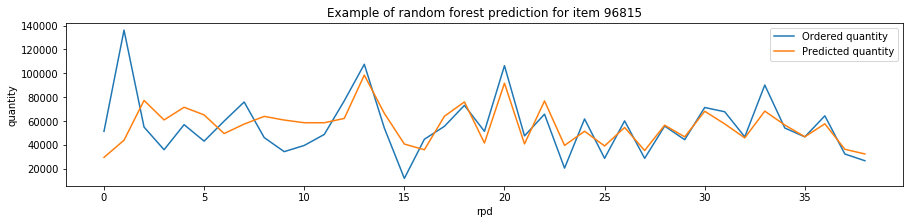

In [187]:
fig = plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of random forest prediction for item 96815')
plt.legend(); 
# ;
t = fig

### Now let's compare it with prediction without future_flag

In [36]:
X_quantity_item_wo_flag = X_quantity_item.loc[:,('0-0','0-96815')]

y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]

In [37]:
y_predicted_wo_flag = []
for i in range(110,152):
    if (X_quantity_item_wo_flag.loc[i:i].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        X_input = [X_quantity_item_wo_flag.loc[108:i]]
        #X_input = [X_quantity_item_wo_flag.loc[108:i].values,None]
#
        regr.fit(  np.array(X_input).transpose()  ,np.array(y_quantity_item).ravel()[0:(i-108)])
        #y_predicted_on_train.append(regr.predict(X_quantity_item.loc[(i):(i),:])[0])
        #y_predicted.append( regr.predict(X_quantity_item.loc[i:i,:])[0])
        if (X_quantity_item_wo_flag.loc[(i+1):(i+1)].size!=0):
            #print(X_quantity_item.loc[(i+1):(i+1),:])
            #print(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
            X_test =np.array(X_quantity_item_wo_flag.loc[(i+1):(i+1)])
            y_predicted_wo_flag.append(regr.predict([X_test])[0] )

In [38]:
round(mean_squared_error(np.array( y_quantity_item[2:]).ravel(), y_predicted_wo_flag),2)

844037048.96

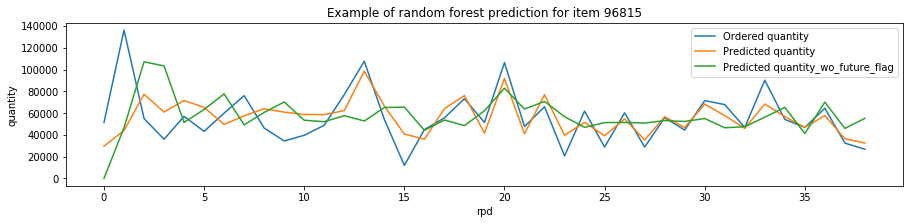

In [39]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
y_predicted_wo_flag.insert(0,0)
plt.plot(y_predicted_wo_flag , label = 'Predicted quantity_wo_future_flag')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of random forest prediction for item 96815')
plt.legend(); 
# ;

### GradientBoostingRegressor

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
        regr = GradientBoostingRegressor(**params)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
round(mean_squared_error(np.array( y_quantity_item[1:]).ravel(), y_predicted),2)

496964986.8

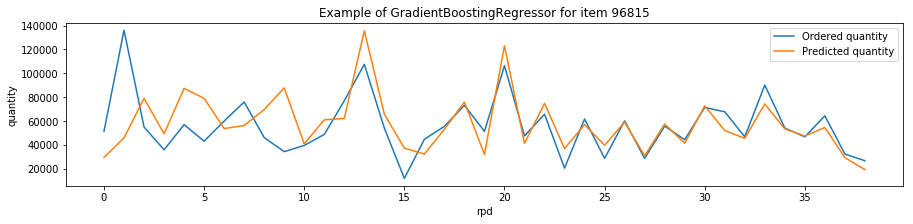

In [41]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
y_predicted_wo_flag.insert(0,0)
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of GradientBoostingRegressor for item 96815')
plt.legend(); 

### SVM Regression


In [42]:
from sklearn.svm import SVR
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = SVR(gamma=0.001, C=1.0, epsilon=0.2)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
mean_squared_error(np.array( y_quantity_item[1:]).ravel(), y_predicted)

685889428.8184617

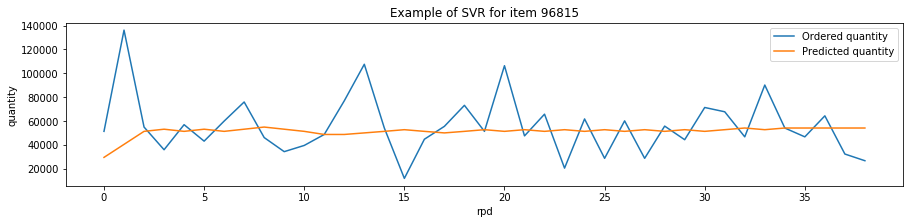

In [43]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of SVR for item 96815')
plt.legend(); 

### Kernel Regression

In [44]:
from sklearn.kernel_ridge import KernelRidge
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = KernelRidge(alpha=1.0)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
mean_squared_error(np.array( y_quantity_item[1:]).ravel(), y_predicted)

529829039.1234263

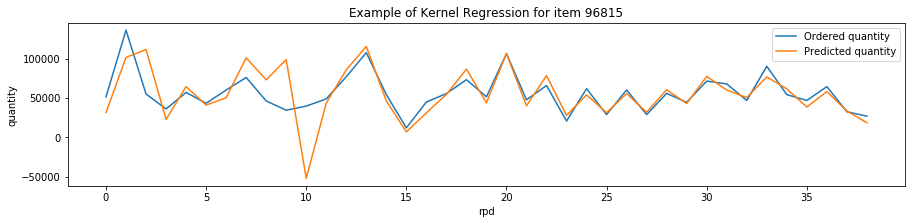

In [45]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of Kernel Regression for item 96815')
plt.legend(); 


### Let's estimate all Y using random forest

In [216]:
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1]

In [217]:
y_pred_1_0 =[]
y_pred_2_0 = []
y_pred_2_1 = []
y_pred_3_0 = [] 
y_pred_3_1 = [] 
y_pred_3_2 = []
y_pred_4_0 = []
y_pred_4_1 = []
y_pred_4_2 = [] 
y_pred_4_3=[]

In [218]:
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('1-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_1_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('2-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_2_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('2-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_2_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-2',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_2.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-2',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_2.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-3',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_3.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        

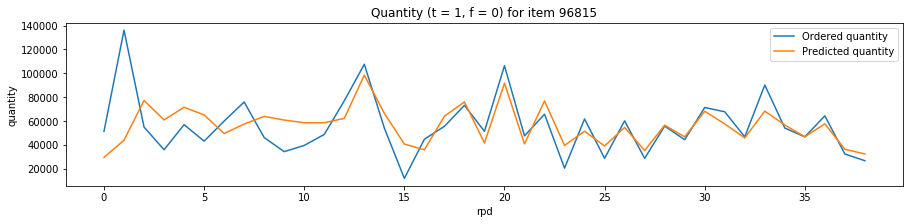

In [50]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('1-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_1_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 1, f = 0) for item 96815')
plt.legend(); 

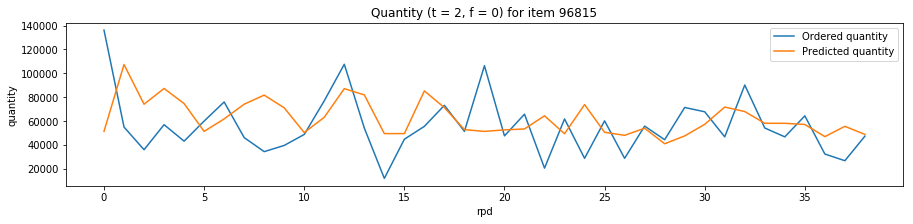

In [51]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('2-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_2_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 2, f = 0) for item 96815')
plt.legend(); 

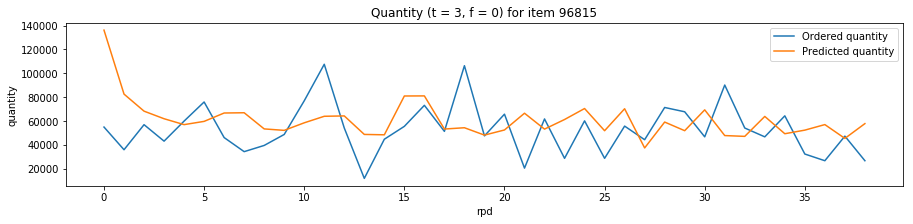

In [52]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('3-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_3_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 3, f = 0) for item 96815')
plt.legend(); 

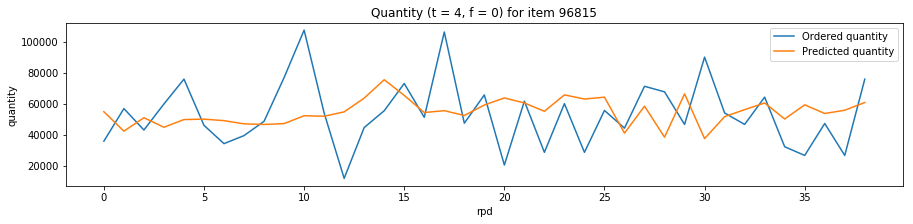

In [53]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('4-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_4_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 4, f = 0) for item 96815')
plt.legend(); 

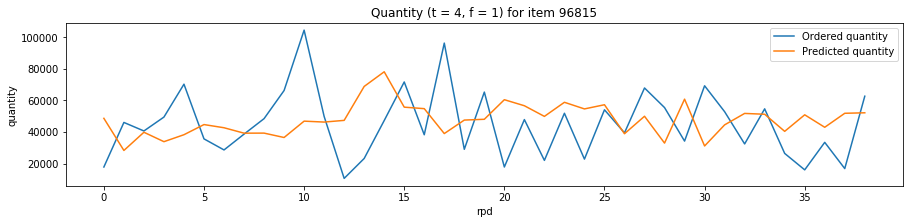

In [54]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_4_1, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 4, f = 1) for item 96815')
plt.legend(); 

In [55]:
round(mean_squared_error(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:], y_pred_4_1),2)

664611338.83

In [219]:
np.array([[0,0,0,0],
         [round(mean_squared_error(np.array(y_quantity_item.loc[:,('1-0',slice(None))])[1:], y_pred_1_0),2),
          0,0,0],
         [round(mean_squared_error(np.array(y_quantity_item.loc[:,('2-0',slice(None))])[1:], y_pred_2_0),0),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('2-1',slice(None))])[1:], y_pred_2_1),0),
          0,0],
         [round(mean_squared_error(np.array(y_quantity_item.loc[:,('3-0',slice(None))])[1:], y_pred_3_0),2),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('3-1',slice(None))])[1:], y_pred_3_1),2),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('3-2',slice(None))])[1:], y_pred_3_2),2),
          0],
         [round(mean_squared_error(np.array(y_quantity_item.loc[:,('4-0',slice(None))])[1:], y_pred_4_0),2),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:], y_pred_4_1),2),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('4-2',slice(None))])[1:], y_pred_4_2),2),
          round(mean_squared_error(np.array(y_quantity_item.loc[:,('4-3',slice(None))])[1:], y_pred_4_3),2)]])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.09738924e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.23479887e+08, 7.90798077e+08, 0.00000000e+00, 0.00000000e+00],
       [7.23349464e+08, 6.99475134e+08, 7.53404168e+07, 0.00000000e+00],
       [5.57321631e+08, 6.64611339e+08, 1.26179259e+08, 5.42432444e+07]])

Let's try all items

In [57]:
quantity_all_items = make_Xy(qty_total)

In [58]:
item_ = df.filter(like= '96815',axis = 0)

In [59]:
all_items = set(df.index.get_level_values('item'))
#save plots

In [98]:
mse_per_item = {}
plot_per_item = {}
for it in all_items:
    item_ = df.filter(like=str(it),axis = 0)
    demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
    qty_total_item = demand_total_item.unstack("item", fill_value=0.)
    t = make_Xy(qty_total_item)
    y_predicted = []
    X_quantity_item = t[0].loc[108:151,:]
    y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
    for i in range(108,152):
        if (X_quantity_item.loc[i:i,:].size==0):
            continue
        else:
            regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
            regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,:]).ravel())
            if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
    plot_per_item [it] = plt_2_gr(y_quantity_item,y_predicted,'Item '+str(it)+' Random Forest')
    plt.close()
    if (len(y_predicted)>1):
        mse_per_item[it]=round(mean_squared_error(np.array(y_quantity_item[1:len(y_predicted)+1]), y_predicted),1)
    #break

In [120]:
#but mse all also depends on the amount of volume of shipment. Should normalize?
from collections import OrderedDict
from operator import itemgetter
d = OrderedDict(sorted(mse_per_item.items(), key=itemgetter(1)))
i = 0
for idx in d.keys():
    if (i>5):
        break
    print(idx,d[idx])
    i+=1

35996 0.0
93447 13807.7
55743 18625.3
87225 45447.0
94903 46462.7
80510 58642.0


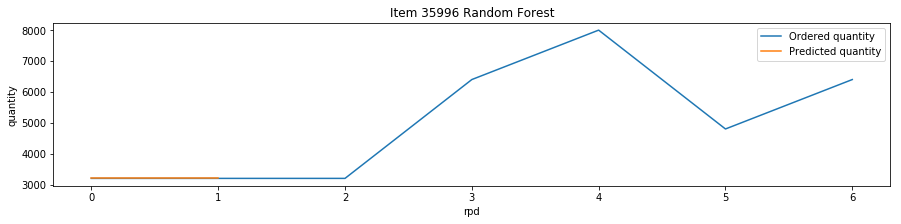

In [139]:
plot_per_item[35996]

In [132]:
i = 0
for idx in reversed(d.keys()):
    if (i>5):
        break
    print(idx,d[idx])
    i+=1
  
    

94698 8078851466640800.0
48635 53409737839662.8
99123 1696352825898.7
86323 417014073191.8
10949 408394026956.2
58781 210911629786.5


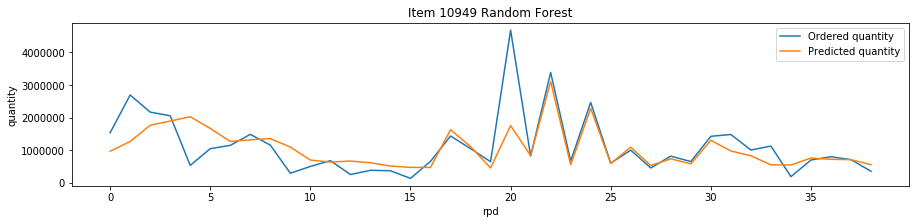

In [138]:
plot_per_item[10949]